<a href="https://colab.research.google.com/github/Srikar1718/Super-Resolution-of-Pixelated-Images-with-SRGAN-and-EDSR/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow_datasets


In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

In [ ]:
def preprocess_div2k(lr_img, hr_img):
    lr_img = tf.image.resize(lr_img, [24, 24])
    hr_img = tf.image.resize(hr_img, [96, 96])
    lr_img = tf.cast(lr_img, tf.float32) / 255.0
    hr_img = tf.cast(hr_img, tf.float32) / 255.0
    return lr_img, hr_img

train_ds = tfds.load('div2k/bicubic_x4', split='train', as_supervised=True)
train_ds = train_ds.map(preprocess_div2k).shuffle(1024).batch(16)


In [ ]:
def build_generator():
    inputs = Input(shape=(24, 24, 3))
    x = Conv2D(64, 9, padding='same', activation='relu')(inputs)
    skip = x
    for _ in range(16):
        x = Conv2D(64, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(64, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, skip])
        skip = x
    x = Conv2D(64, 3, padding='same')(x)
    x = Add()([x, skip])
    x = UpSampling2D()(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = Conv2D(3, 9, padding='same', activation='tanh')(x)
    return Model(inputs, x)

def build_discriminator():
    def conv_block(x, filters, strides):
        x = Conv2D(filters, 3, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    inp = Input(shape=(96, 96, 3))
    x = Conv2D(64, 3, strides=1, padding='same')(inp)
    x = LeakyReLU(0.2)(x)
    filters = [64, 128, 128, 256, 256, 512, 512]
    strides = [2, 1, 2, 1, 2, 1, 2]
    for f, s in zip(filters, strides):
        x = conv_block(x, f, s)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

def build_vgg():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False
    return model

In [ ]:
generator = build_generator()
discriminator = build_discriminator()
vgg = build_vgg()

bce = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(lr_imgs, hr_imgs):
    valid = tf.ones((tf.shape(lr_imgs)[0], 1))
    fake = tf.zeros((tf.shape(lr_imgs)[0], 1))

    with tf.GradientTape() as gtape, tf.GradientTape() as dtape:
        fake_hr = generator(lr_imgs)
        real_logits = discriminator(hr_imgs)
        fake_logits = discriminator(fake_hr)

        d_loss_real = bce(valid, real_logits)
        d_loss_fake = bce(fake, fake_logits)
        d_loss = (d_loss_real + d_loss_fake) / 2

        real_feat = vgg(preprocess_input(hr_imgs * 255.0))
        fake_feat = vgg(preprocess_input(fake_hr * 255.0))
        perceptual_loss = mse(real_feat, fake_feat)

        g_loss = 1e-3 * bce(valid, fake_logits) + perceptual_loss

    grads_g = gtape.gradient(g_loss, generator.trainable_variables)
    grads_d = dtape.gradient(d_loss, discriminator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    return g_loss, d_loss

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training loop
epochs = 2  # Set low for testing; increase for better results
steps_per_epoch = 50  # Adjust as needed for Colab memory

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    step = 0
    for lr_batch, hr_batch in train_ds.take(steps_per_epoch):
        g_loss, d_loss = train_step(lr_batch, hr_batch)
        if step % 10 == 0:
            print(f"Step {step}: Gen Loss = {g_loss:.4f}, Disc Loss = {d_loss:.4f}")
        step += 1



Epoch 1/2
Step 0: Gen Loss = 111.2745, Disc Loss = 0.5321
Step 10: Gen Loss = 92.6757, Disc Loss = 0.0098
Step 20: Gen Loss = 79.2245, Disc Loss = 3.9148
Step 30: Gen Loss = 68.8463, Disc Loss = 0.0757
Step 40: Gen Loss = 80.4350, Disc Loss = 0.1798

Epoch 2/2
Step 0: Gen Loss = 81.5178, Disc Loss = 0.0590
Step 10: Gen Loss = 83.2979, Disc Loss = 0.0275
Step 20: Gen Loss = 107.4257, Disc Loss = 0.0113
Step 30: Gen Loss = 102.6772, Disc Loss = 0.0049
Step 40: Gen Loss = 92.4601, Disc Loss = 0.0029


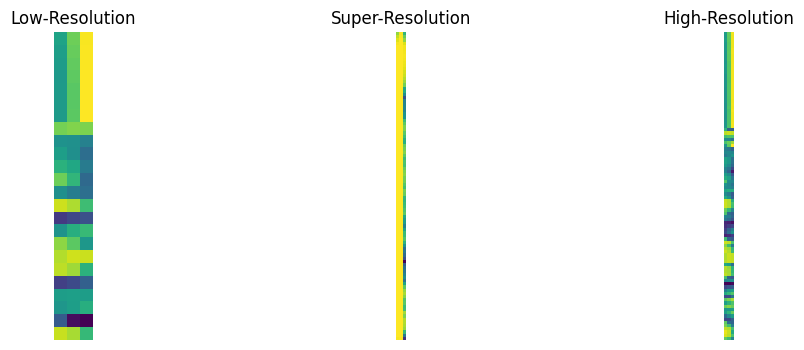

In [ ]:
# Load validation data (used as test data here)
import tensorflow_datasets as tfds

test_ds = tfds.load('div2k/bicubic_x4', split='validation', as_supervised=True)

# Preprocess test images to match training input size
def preprocess_div2k(lr_img, hr_img):
    lr_img = tf.image.resize(lr_img, [24, 24])
    hr_img = tf.image.resize(hr_img, [96, 96])
    lr_img = tf.cast(lr_img, tf.float32) / 255.0
    hr_img = tf.cast(hr_img, tf.float32) / 255.0
    return lr_img, hr_img

test_ds = test_ds.map(preprocess_div2k).batch(1)

# Run on test data
for lr_test, hr_test in test_ds.take(1):
    sr_test = generator(lr_test)
    plot_images(lr_test[0], sr_test[0], hr_test[0])


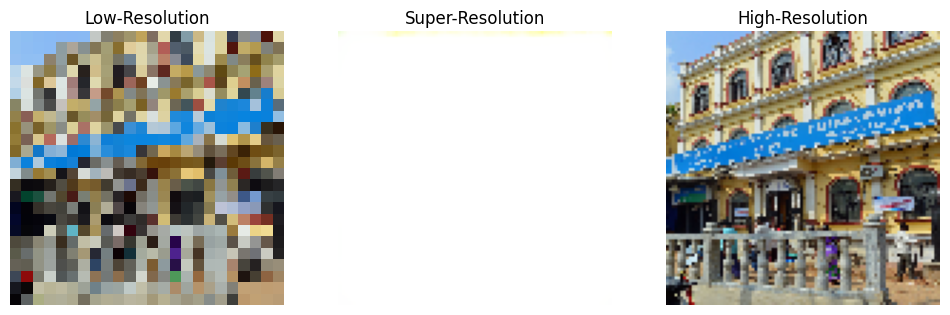

In [ ]:
import matplotlib.pyplot as plt

def plot_images(lr, sr, hr, idx=0):
    """Visualize low-res, super-res, and high-res images side-by-side."""
    plt.figure(figsize=(12, 4))

    titles = ['Low-Resolution', 'Super-Resolution', 'High-Resolution']
    images = [lr[idx], sr[idx], hr[idx]]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Run on test data
for lr_test, hr_test in test_ds.take(1):
    sr_test = generator(lr_test)
    plot_images(lr_test, sr_test, hr_test)
